# Imports 

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import networkx as nx
import scipy.io
import pickle
from pagerank import PageRankGraph

In [2]:
sns.set_palette(palette='deep', n_colors=1)

# Load datasets

In [3]:
wiki_matrix = scipy.io.loadmat('data/simple_wiki_matrix.mat')['W']
stan_graph = nx.read_edgelist("data/web-Stanford.txt", create_using=nx.DiGraph(), nodetype=int)

In [4]:
articles_ = []
with open('data/simple_wiki_dict.pickle', 'rb') as f:
    while True:
        try:
            temp = pickle._Unpickler(f)
            temp.encoding = 'utf-8'
            articles_.append(temp.load())
        except EOFError:
            break

articles = articles_[0]

# PageRank methods

In [5]:
prg = PageRankGraph(data=stan_graph)

In [16]:
df = pd.DataFrame(index=np.arange(1, prg.size + 1))

## Power method

In [8]:
n_iter = 200
pm_ranks, pm_residuals = prg.power_method(x0=np.ones(prg.size) / prg.size, n_iter=n_iter, return_residuals=True)

In [18]:
df['Power method ranks'] = pm_ranks
df.sort_values(by='Power method ranks', ascending=False).head()

,Power method ranks
89073,0.011303
226411,0.009268
241454,0.008297
262860,0.003023
134832,0.003001


## Markov chain Monte Carlo

In [20]:
mcmc_ranks = prg.mcmc(n_iter=int(1e5))

In [23]:
df['MCMC ranks'] = mcmc_ranks
df.sort_values(by='MCMC ranks', ascending=False).head()

,Power method ranks,MCMC ranks
89073,0.011303,0.01098
226411,0.009268,0.00949
241454,0.008297,0.00861
134832,0.003001,0.00320
262860,0.003023,0.00288


## Frank-Wolfe

In [27]:
n_iter = 1000
fw_ranks, fw_targets, fw_residuals = prg.frank_wolfe(x0=np.ones(prg.size)/prg.size, 
                                                    n_iter=n_iter, step='line_search', 
                                                    return_targets=True, return_residuals=False)


In [29]:
len(fw_targets)

1000

Text(0.5,0,'Iterations')

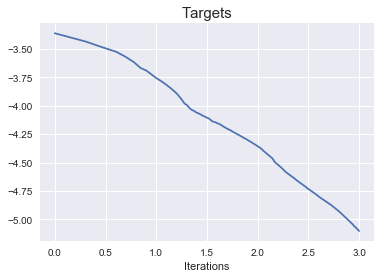

In [32]:
n_last = n_iter
plt.plot(np.log(np.arange(n_iter - n_last, n_iter)) / np.log(10), np.log(fw_targets[-n_last:]) / np.log(10))
plt.title('Targets', fontsize=15)
plt.xlabel('Iterations')

In [37]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.log(np.arange(1, n_iter + 1)).reshape(-1, 1), np.log(fw_targets).reshape(-1, 1))
model.coef_

array([[-0.68042557]])

In [38]:
df['Frank-Wolfe ranks'] = fw_ranks
df.sort_values(by='Frank-Wolfe ranks', ascending=False).head()

,Power method ranks,MCMC ranks,Frank-Wolfe ranks
226411,0.009268,0.00949,0.017018
89073,0.011303,0.01098,0.014978
241454,0.008297,0.00861,0.013002
134832,0.003001,0.00320,0.006751
67756,0.002301,0.00210,0.005756


In [40]:
np.linalg.norm(fw_ranks - pm_ranks)

0.016087932448429067

In [41]:
np.linalg.norm(mcmc_ranks - pm_ranks)

0.0040994712318936834

# English Wikipedia

## Compute

In [42]:
wiki = PageRankGraph(data=wiki_matrix)

In [44]:
x0 = np.random.uniform(size=wiki.size)
x0 /= np.linalg.norm(x0, ord=1)
n_iter = 200
wiki_pm_ranks, wiki_pm_residuals = wiki.power_method(x0=x0, n_iter=n_iter, return_residuals=True)

In [49]:
wiki_mcmc_ranks = wiki.mcmc(n_iter=int(1e5))

In [50]:
wiki_df = pd.DataFrame(index=np.arange(1, wiki.size + 1))
wiki_df['Power Method ranks'] = wiki_pm_ranks
wiki_df['MCMC ranks'] = wiki_mcmc_ranks
wiki_df.sort_values(by='Power Method ranks', ascending=False).head()

,Power Method ranks,MCMC ranks
880,0.002905,0.00309
69741,0.002068,0.00247
113673,0.001544,0.00169
486,0.001356,0.00145
34525,0.001286,0.00133


In [112]:
wiki_fw_ranks, wiki_fw_targets, wiki_fw_residuals = wiki.frank_wolfe(x0, n_iter=1000, step='line_search', 
                                                                     return_targets=True, return_residuals=True)


## Results

In [57]:
top_k = 5
pm_top_indices = np.argsort(wiki_pm_ranks)[-top_k:]
mcmc_top_indices = np.argsort(wiki_mcmc_ranks)[-top_k:]
#fw_top_indices = np.sort(wiki_fw_ranks)[-top_k:]

In [58]:
pm_top_indices

array([ 34524,    485, 113672,  69740,    879])

In [59]:
print('Top wiki articles, according to ranks derived with power method')
for i in range(top_k):
    print("{}. {}".format(i + 1, articles[pm_top_indices[top_k - 1 - i]]))
print()

print('Top wiki articles, according to ranks derived with MCMC method')
for i in range(top_k):
    print("{}. {}".format(i + 1, articles[mcmc_top_indices[top_k - 1 - i]]))
print()

#print('Top wiki articles, according to ranks derived with Frank-Wolfe method')
#for i in range(top_k):
#    print("{}. {}".format(i + 1, articles[fw_top_indices[top_k - 1 - i]]))
#print()

Top wiki articles, according to ranks derived with power method
1. United_States
2. Multimedia
3. Geographic_coordinate_system
4. France
5. Americans

Top wiki articles, according to ranks derived with MCMC method
1. United_States
2. Multimedia
3. Geographic_coordinate_system
4. France
5. Internet_Movie_Database

